In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from scipy.ndimage.interpolation import shift

By default scikit learn downloads datasets in a folder with directory $HOME/scikit_learn_data

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Dataset structure in sklearn
-----
Datasets have generally the same DICT structure in scikit learn :  

-> a DESCR key : describes the dataset  
-> a data key : contains an array with one row per instance and one column feature  
-> a target key : contains an array with labels

In [4]:
X, y = mnist["data"], mnist["target"]
print("dim data set: ", X.shape, "\ndim label set : ", y.shape)

dim data set:  (70000, 784) 
dim label set :  (70000,)


Each image as 784 features because it's a 28x28 pixel binary image

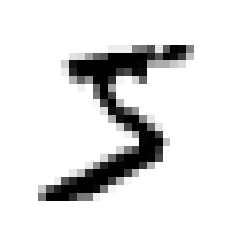

label :  5


In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
print("label : ", y[0])

Labels
-----
Labels are string type and most ML algorithms takes int type labels, so labels must be converted to np.uint8

In [6]:
y = y.astype(np.uint8)

Creates train & test set
----
The training set is already shuffled for us so we don't need to introduce random selection 

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

-----
Binary Classifier
-----
-----
Training 5 detector that differenciates 5 from non 5 numbers

In [8]:
y_train5 = (y_train == 5)
y_test5 = (y_test==5)

Stochastic Gradient Descent
----
 * capabe of handling large datasets.  
 * deals with training instances independantly.  

SDG uses randomness when training, so if we want reproducible result, random_state should be set

In [49]:
sgd_clf = SGDClassifier(random_state=42)


In [10]:
sgd_clf.fit(X_train, y_train5)
sgd_clf.predict([some_digit])

array([ True])

Performance Measure for binary classifier
----
It's trickier for a classifier than with a regressor

Using Cross validation
----
Firstly, we implement our own cross validation function, then, we use sklearn cross_validation_score function

In [11]:
def self_cross_validation(sgd_clf, X_train, y_train5):
    skfolds = StratifiedKFold(n_splits=3, random_state=42)

    for train_index, test_index in skfolds.split(X_train, y_train5):
        clone_clf = clone(sgd_clf)
        X_train_folds = X_train[train_index]
        y_train_folds = y_train5[train_index]
        X_test_folds = X_train[test_index]
        y_test_folds = y_train5[test_index]
        
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_folds)
        n_correct = sum(y_pred == y_test_folds)
        print(n_correct/len(y_pred))

self_cross_validation(sgd_clf, X_train, y_train5)

0.95035
0.96035
0.9604


In [12]:
cross_val_score(sgd_clf, X_train, y_train5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

The Never5 classifier has more than 90% accuracy that's because there is around 10% of 5s in the dataset. It shows also why ***accuracy isn't the performance measure that we generally use***. 

In [14]:
never_5_class = Never5Classifier()
cross_val_score(never_5_class, X_train, y_train5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Using Confusion Matrix
-----
the general idea is to count the number of times, instances of class A are classified as class B.  

Cross_val_predict = performs K-folds cross validation, returns the prediction on each fold, the predictions are made by a model that never saw the other training folds 

In [15]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train5, cv=3)

Confusion matrix
----
true negative = TN  &nbsp;| false positive = FP &nbsp;<- negative class  
\-------------------------------------------------  
false negative = TN | true positive = TP &nbsp;&nbsp;<- positive class

In [16]:
confusion_matrix(y_train5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
y_train_perfect_pred = y_train5
confusion_matrix(y_train5, y_train_perfect_pred)

array([[54579,     0],
       [    0,  5421]])

Precision
----
Have a better look at positive predictions = TP/(TP+FP)
Recall
------
Have a better look at negative predictions = TP/(TP+FN)

In [18]:
print(precision_score(y_train5, y_train_pred))
print(recall_score(y_train5, y_train_pred))

0.8370879772350012
0.6511713705958311


F1 score
----
f1_score computes the harmonic mean of precision and recall. It could be useful to compare 2 models of classifier. It favours the model that have similar precision and recall.

In [19]:
f1_score(y_train5, y_train_pred)

0.7325171197343846

Instead of using predict function, we can use decision function in order to see the score of the image

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

Threshold value
----
How to decide which threshold value to choose

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train5, cv=3, method="decision_function")

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.grid()
    plt.axis([-40000, 40000, 0, 1])
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()

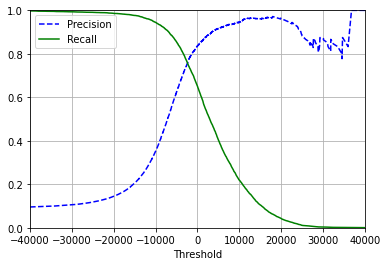

In [23]:
precisions, recalls, thresholds = precision_recall_curve(y_train5, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

To compute theshold when the precision is over 90 % we could use np.argmax(precision>0.90)

In [24]:
threshold_90_precision = thresholds[np.argmax(precisions>0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [25]:
print(precision_score(y_train5, y_train_pred_90))
print(recall_score(y_train5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


The Receiver Operating Characteristic (ROC)
-----
tool with binary classifier. ROC curve plots the true positive rate(same as recall) against the False Positive Rate(FPR). The True Negative Rate also called specificity. The ROC curve plots sensivity (recall) versus 1-specificity

In [28]:
fpr, tpr, thresholds = roc_curve(y_train5, y_scores)

In [44]:
def plot_roc_curve(fpr, tpr, trace_type="b-", label=None):
    plt.plot(fpr, tpr, trace_type, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #Dashed diagonal
    plt.grid("on")
    plt.ylabel('tpr')
    plt.xlabel('fpr')
    

A good classifier stays as much as possible on top-left corner of the graph far from the dashed line(random classifier)

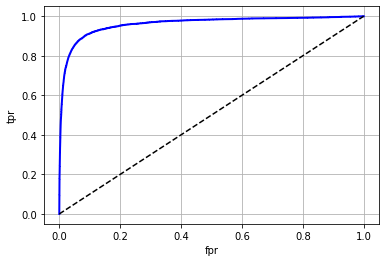

In [38]:
plot_roc_curve(fpr, tpr)
plt.show()

Area Under Curve
----
To compare classifier : Area Under Curve(AUC), 1 is perfect classifier, 0.5 is a random classifier

In [34]:
roc_auc_score(y_train5, y_scores)

0.9604938554008616

PR curve vs ROC curve
-----
PR curve : whenever positive class is rare or you care more about FP than FN  
ROC curve: otherwise 

Random Forest Classifier
-----
 - does not have decision_function() 
 - Instead it has predict_proba() : returns an array containing a row per instance and a column per class, each containing the probabilty the the given instance belongs to the given class
 

In [40]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train5, cv=3, method="predict_proba")

In [41]:
y_scores_forest = y_probas_forest[:,1] #score = proba of positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train5, y_scores_forest)

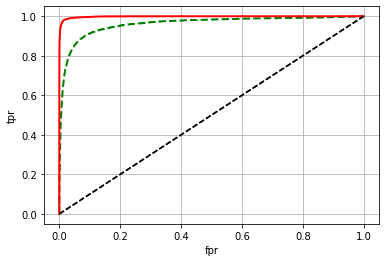

In [45]:
plot_roc_curve(fpr, tpr, trace_type="g--")
plot_roc_curve(fpr_forest, tpr_forest, trace_type="r-")
plt.show()

In [70]:
def evaluate_bin_model(y_train5, y_scores):
    print("ROC AUC score : ", roc_auc_score(y_train5, y_scores))
    print("Precision score : ", precision_score(y_train5, y_scores.round()))
    print("Recall score", recall_score(y_train5, y_scores.round()))
    print("F1 score : ", f1_score(y_train5, y_scores.round()))

In [71]:
evaluate_bin_model(y_train5, y_scores_forest)

ROC AUC score :  0.9983436731328145
Precision score :  0.9905083315756169
Recall score 0.8662608374838591
F1 score :  0.9242275142688446


We use *round()* function in order to set all the number of random forest score to round value(0 or 1), it means the evalution is made with a threshold of 0.5

In [72]:
print(y_scores_forest, "\n")
print(y_scores_forest.round(), "\n")

[0.89 0.01 0.04 ... 0.98 0.08 0.06] 

[1. 0. 0. ... 1. 0. 0.] 



-----
Multiclass Classification (Multinomial Classifier)
-----
-----
 - Some Algo capable to handle multiple classes natively : Random Forest, SGD, naive Bayes   
 - Algo stricly binary Classifier : Logistic Regression, Support Vector Machine
  
However, there are strategies to perform multiclass classifier with multiple binary classifier.  
For example, to detect numbers, we could divide into 10 classes (0 to 9), and create binary classifier for each number, we then select the class whose classifier puts the highest score. It's called **one-versus-the-rest strategy**.  
  
An other strategy is to train binary classifier to detect 2 classes (0 with 1, 0 with 2, ..., 8 with 9), it means training N*(N-1)/2 model for N classes. It's called **One-versus-one strategy**. Some classifier scale poorly with large dataset(SVM for example), in this case O-v-O strategy is prefered, because it's faster to train many classifer on small datasets than one classifer on large datasets.  
  
Most of the time, O-v-R is prefered.

SVC Classifier
-----
**OvO strategy (45 bin Classifier)**

In [7]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

If we call decision function, it will return 10 scores per instance

In [9]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]
5
[0 1 2 3 4 5 6 7 8 9]


**OvR strategy**

In [11]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [13]:
print(ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))

[5]
10


SGD Classifier
----
Muliclass Classifier, so it trains only one model

In [10]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [11]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [12]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

It gets over 84% accuracy on all test folds but we could increase the result by simply ___scaling___ the input !

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [ ]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3)

In [54]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

----
Error Analysis
----
----
When we have done with data preparation, try different model, fine-tuned the model, we want to improve the model it could be done by analysing the errors it makes.

Confusion matrix
-----

In [55]:
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


That's more convenient to look at the image of matrix with mathshow() function

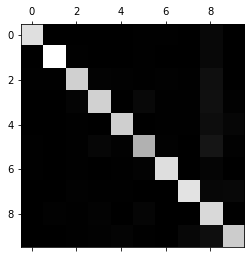

In [16]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

However this image is not satisfying because it depends on the number of element per class, so we divide each line by the number of element in the class. We **normalize confusion matrix**

In [36]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

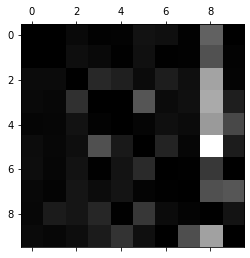

In [38]:
np.fill_diagonal(norm_conf_mx, 0) #to keep only the errors on the image
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

It could be seen that the algorithm detects pretty well 8 (dark row), but mistakes often the other number with 8(light column)  
To improve the detection of 8 we could:  
 * increase the dataset with 8
 * engineer a new feature that help the classifier (ex : algo that counts the number of closed loops : 8 has two, 6 has one 5 has zero)
 * preprocess the image with scikit-image, Pillow or opencv

In [56]:
cl_a, cl_b = 3, 5
X_aa = X_train[y_train == cl_a & (y_train_pred == cl_a)]
X_ab = X_train[y_train == cl_a & (y_train_pred == cl_b)]
X_ba = X_train[y_train == cl_b & (y_train_pred == cl_a)]
X_bb = X_train[y_train == cl_b & (y_train_pred == cl_b)]

In [57]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [58]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

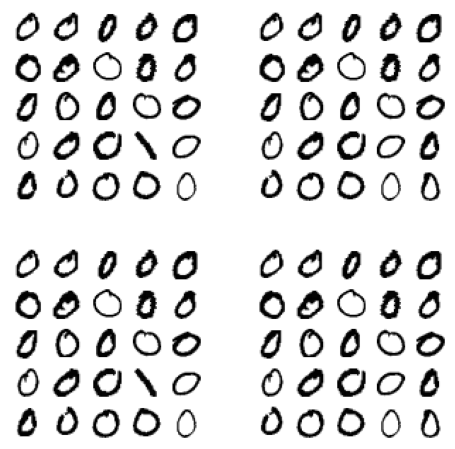

In [59]:
plt.figure(figsize = (8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)

----
Multilabel classification 
----
____

A classifier outputs multiple classes for each instances (ex : face recognition with several person on the picture) is called Multilabel classification 

In [61]:
y_train_large = (y_train>=7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

KNeighbors classifier
----
This classifier is a multilabel classifier

In [8]:
knn_clf = KNeighborsClassifier()

In [ ]:
knn_clf.fit(X_train, y_multilabel)

In [63]:
knn_clf.predict([some_digit])

array([[False,  True]])

To evaluate the classification we could use F1 score, it measures the F1 score for each label and then compute the average score. This assume that all labels are equally important, if there is one or several classes that have more instances we could use *average="weighted"* argument in F1 score function 

In [64]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

----
Multioutput Classification
----
----
It's a generalization of multilabel classification where each label can be multiclass

In this example, we add a random noise to dataset and we try to clean the noise with the output for training the original dataset

In [66]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[5]])
plot_digit(clean_digit)

Data Augmentation
----
We create a function that add all the train set shifted by one pixel up, down, left and right to improve the training, it's called data augmentation. 

In [15]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)
    

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
param_grid = [{'weights': [3,10,30],'n_neighbors': [2,4,6,8]}]

grid_search = GridSearchCV(knn_clf, param_grid, cv=5,
                          scoring = "neg_mean_squared_error",
                          return_train_score=True)

In [ ]:
final_model = grid_search.best_estimator_

In [ ]:
cross_val_score(final_model, X_train, y_train, cv=3, scoring="accuracy")